In [1]:
# For symbolic calculations
import sympy as sp
# For numeric calculations
import numpy as np

# For plotting
import matplotlib.pyplot as plt

from inflationpy import SlowRollModel, SlowRollEndSolver, FunctionAsolver, FunctionBsolver, FunctionVsolver

# Notebook for calculating unknown functions

\begin{equation}
    S = \int d^4x \sqrt{-g} \left\{ \frac{M_p^2}{2} A(\phi)R  -\frac{1}{2}B(\phi)g^{\mu \nu} \nabla_{\mu} \phi \nabla_{\nu} \phi -  V(\phi)  \right \}
\end{equation} 

## 1) Define model functions

To start calculating, required symbols must be defined. By default SlowRollModel assumes that 'phi' is used as scalar field ('I_phi' for invariant field) symbol and 'M_p' as Planck's mass. If other symbols are used then this information must be given to the SlowRollModel class.

To define symbols and equations it is advised to use sympy although it can try to convert strings to equations as well this method is not too reliable. To look more how to define functions with sympy: https://docs.sympy.org/latest/modules/functions/index.html#contents

In [2]:
# Define symbols. phi for scalar field and I_phi for invariant scalar field.
phi, I_phi = sp.symbols('phi I_phi', real=True)
# Define model specific free parameters and Planck's mass
alpha, M_p = sp.symbols('alpha M_p', real=True, positive=True)
# Also program uses some default symbols: 'N' for e-folds
N = sp.symbols('N', real=True, positive=True)

In [3]:
# Define functions. 
A = 1
B = 6*alpha/(phi/M_p-1)**2
V = (phi/M_p - 2)**2 * (phi/M_p)**2/((phi/M_p)**2 - 2*phi/M_p + 2)**2
I_V = sp.tanh(I_phi/(sp.sqrt(6*alpha)*M_p))**2

Put all functions into SlowRollModel class which then sets up all required combinations for later calculations. It is possible to define only some of the functions. Although to calculate observables (A, B, V) or invariant potential must be defined. 

When only invariant potential is defined then it is possible to use it two ways:
Set: A=1, B=1 and V=invariant potential or set I_V = invariant potential.

\begin{equation}
S = \int d^4x \sqrt{-g} \left\{ \frac{M_p^2}{2} R  -\frac{1}{2}g^{\mu \nu} \nabla_{\mu} I_\phi \nabla_{\nu} I_\phi -  I_V(I_\phi)  \right \} 
\end{equation}

Invariant functions are defined as:

\begin{equation}
    I_V = \frac{V}{A^2}
\end{equation}
\begin{equation}
    I_\phi = \int \sqrt{\frac{B}{A} + \delta_\Gamma \frac{3}{2} M_p^2 \left(\frac{A'}{A}\right)^2} d\phi
\end{equation}

where $\delta_\Gamma = 1$ for metric formalism and $0$ for Palatini.

SlowRollModel will calculate following equations:
1) Slow-roll parameters $\epsilon$ and $\eta$.
2) For scalar field $F(\phi) = \frac{B}{A} + \delta_\Gamma \frac{3}{2} M_p^2 \left(\frac{A'}{A}\right)^2$
3) Also N-fold integrand $\frac{AVF}{AV'-2VA'} = \frac{I_V'}{I_V}$
4) Observable functions from $\epsilon$ and $\eta$.

In [4]:
# A, B, V and I_V and functions which are possible to define
# palatini (True/False) - to use Palatini formalism or not
# symbol is set to phi (this is actually not required if phi=sp.Symbol('phi', real=True))
# Planck's mass symbol/value is set to M_p (this is actually not required if mp=sp.Symbol('M_p', real=True, positive=True))
model = SlowRollModel(A=A, B=B, V=V, I_V=I_V, palatini=False, symbol=phi, mp=M_p)
# Try to simplify all functions (also which are calculated in model). This might make later calculations easier/faster.
model.simplify()
model

A= 1
B= 6*alpha/(-1 + phi/M_p)**2
V= phi**2*(-2 + phi/M_p)**2/(M_p**2*(2 - 2*phi/M_p + phi**2/M_p**2)**2)
I_V= tanh(sqrt(6)*I_phi/(6*M_p*sqrt(alpha)))**2

## 2) Find Function A

\begin{equation}
    \frac{dA}{d\phi} = \frac{4AVV' \pm \left \lvert I_\phi^{*} \right \rvert^{-1} \sqrt{16A^5BV^2 + \delta_\Gamma 6M_p^2A^6 \left[{V'}^2 - A^3 B {I_\phi^{*}}^{-2} \right]}}{8V^2  - \delta_\Gamma 3M_p^2 A^4 {I_\phi^{*}}^{-2}}
\end{equation}

This is analytically impossible to solve usually. So we need to turn to numerical solving. This requires to set initial condition. We can use following solution. 
1) As we have invariant potential, we can calculate it's value. For example we calculate invariant potential value at the end of inflation.
2) Insert potential value to invariant potential definition.
3) Select scalar field value for end of inflation and calculate A
\begin{equation}
    A = \sqrt{\frac{V(\phi_{\text{end}})}{I_V(I_{\phi_{\text{end}}})}}
\end{equation}

In [5]:
# Define solver
a_solver = FunctionAsolver(model)
# Define parameter values
parameters = {M_p:1 , alpha:2}
# Find invariant potential inverse function. Currently sympy finds two solutions. We select the sceond solution.
inverse_I_V = a_solver.inverse_invariant_potential()[1]
# Find initial condition for function. For that we use invariant potential definition.
end_value_solver = SlowRollEndSolver(model, invariant=True)
invariant_end = end_value_solver.nsolve_np([0, 2], params=parameters)[0]
# For one sample calculate current model's field value at the end of inflation
end_value_solver2 = SlowRollEndSolver(model, invariant=False)
field_end = end_value_solver2.nsolve_np([0, 5], params=parameters)[0]
# We select initial value such that V/I_V isn't equal to 0/0
# Also B and V functions must behave well. Thus we can see at field=1 we have singularity.
A_initial_value1 = a_solver.return_initial_condition_np(invariant_end_value = invariant_end, field_value=0.1, params=parameters)
# A_initial_value2 corresponds to our current A, B, V functions
A_initial_value2 = a_solver.return_initial_condition_np(invariant_end_value = invariant_end, field_value=field_end, params=parameters)


In [6]:
(model.V.f_s()/model.I_V.f_s()).subs({M_p:1, alpha:2})

phi**2*(phi - 2)**2/((phi**2 - 2*phi + 2)**2*tanh(sqrt(3)*I_phi/6)**2)

Solving differential equation we have to select sign value. This depend on our functions and which way field should move. Currently no good explanation which sign in which case we must take.
Also when choosing initial conditions for scalar field we have to analyze other functions as well to not take values at singulariteis. For B it is $\phi = M_P$.

numerical_solution_1 is solution where for initial condition we take, that scalar field = 0.1 and we calculate A value for that.

numerical_solution_2 is solution where we take known A function and calculation end value for our A, B, V functions. This is only for testin purposes as we don't know that if we try to solve for A. 

In [7]:
# With initial condition phi=1
# From B function we have limitation that at 1 is singularity. Thus we calcualte between (0, 1)
# sc_kwargs let's us change settings for scipy solve_ivp settings
numerical_solution_1 = a_solver.nsolve_np(
    x=[0.1, 0.99],
     y0=A_initial_value1,
     invariant_potential_inverse = inverse_I_V,
     sign='-',
    params=parameters,
    sc_kwargs={'atol':1e-9, 'rtol':1e-9})

numerical_solution_2 = a_solver.nsolve_np(
    x=[field_end, 0.99],
     y0=A_initial_value2,
     invariant_potential_inverse = inverse_I_V,
     sign='-',
    params=parameters,
    sc_kwargs={'atol':1e-9, 'rtol':1e-9})    

Let's test our found functions by plotting these functions.

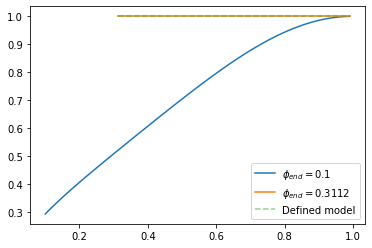

In [8]:
x1 = np.linspace(0.1, 0.99)
x2 = np.linspace(field_end, 0.99)
plt.plot(x1, numerical_solution_1(x1), label=f"$\\phi_{{end}}={0.1}$")
plt.plot(x2, numerical_solution_2(x2), label=f"$\\phi_{{end}}={field_end:.4f}$")
plt.plot(x2, model.A.f_n(x2, M_p=1, alpha=2), linestyle='--', alpha=0.5, label='Defined model')
plt.legend()

We can see that we have two different $A(\phi)$ solutions but this is okay as we used different initial conditions. This means we have different function to convert scalar field to invariant scalar field as well which in the end casuses the difference in A function.

## 3) Find Function B

Calcualting B function is easier in most cases. This only requires to find invariant potential inverse function analytically. 
\begin{equation}
    B = A \left[\left(\frac{dI_\phi}{d\phi}\right) - \delta_\Gamma\frac{3M_p^2}{2}\left(\frac{A'}{A}\right)^2 \right] \ ,
\end{equation}
where $I_\phi = I_\phi(I_V)$ and we substitute $I_V$ with $\frac{V}{A^2}$. Otherwise it is easy to calculate B analytically. Only problem is that sympy can't always simplify given expression to simple forms (if it exists). There are many reasons: first symbolic simplification is complicated and also we don't have correct assumptions for free parameters (and currently sympy does not provide it too).

In [9]:
b_solve = FunctionBsolver(model)
# We can find two solutions. Let's select the second one
invariant_potential_inverse = b_solve.inverse_invariant_potential()[1]
invariant_potential_inverse

sqrt(6)*M_p*sqrt(alpha)*log(-(2*sqrt(I_V) + I_V + 1)**3/(I_V - 1)**3)/6

In [10]:
b_function = b_solve.solve(invariant_potential_inverse = invariant_potential_inverse)
b_function

M_p**2*alpha*(-1 + phi**2*(-2 + phi/M_p)**2/(M_p**2*(2 - 2*phi/M_p + phi**2/M_p**2)**2))**6*(-(1 + 2*Abs(phi)*Abs(2 - phi/M_p)/(M_p*Abs(2 - 2*phi/M_p + phi**2/M_p**2)) + phi**2*(-2 + phi/M_p)**2/(M_p**2*(2 - 2*phi/M_p + phi**2/M_p**2)**2))**2*(-6*(-2/M_p + 2*phi/M_p**2)*Abs(phi)*Abs(2 - phi/M_p)*sign(2 - 2*phi/M_p + phi**2/M_p**2)/(M_p*(2 - 2*phi/M_p + phi**2/M_p**2)**2) + 6*Abs(2 - phi/M_p)*sign(phi)/(M_p*Abs(2 - 2*phi/M_p + phi**2/M_p**2)) + 3*phi**2*(-2 + phi/M_p)**2*(4/M_p - 4*phi/M_p**2)/(M_p**2*(2 - 2*phi/M_p + phi**2/M_p**2)**3) + 6*phi*(-2 + phi/M_p)**2/(M_p**2*(2 - 2*phi/M_p + phi**2/M_p**2)**2) - 6*Abs(phi)*sign(2 - phi/M_p)/(M_p**2*Abs(2 - 2*phi/M_p + phi**2/M_p**2)) + 6*phi**2*(-2 + phi/M_p)/(M_p**3*(2 - 2*phi/M_p + phi**2/M_p**2)**2))/(-1 + phi**2*(-2 + phi/M_p)**2/(M_p**2*(2 - 2*phi/M_p + phi**2/M_p**2)**2))**3 - (1 + 2*Abs(phi)*Abs(2 - phi/M_p)/(M_p*Abs(2 - 2*phi/M_p + phi**2/M_p**2)) + phi**2*(-2 + phi/M_p)**2/(M_p**2*(2 - 2*phi/M_p + phi**2/M_p**2)**2))**3*(-3*phi**2*(

#### Lets compare result with known function
There are couple of notions. We know that there is singularity in point $\phi = M_p$ and $I_\phi=0$ which corresponds to $\phi=0$ (look potential) can't be calculated, as $\epsilon_{I_\phi}$ is not defined. We can see conditions for invariant field with

In [11]:
model.inspect(invariant=True);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0.5, 0, '$\\phi$')

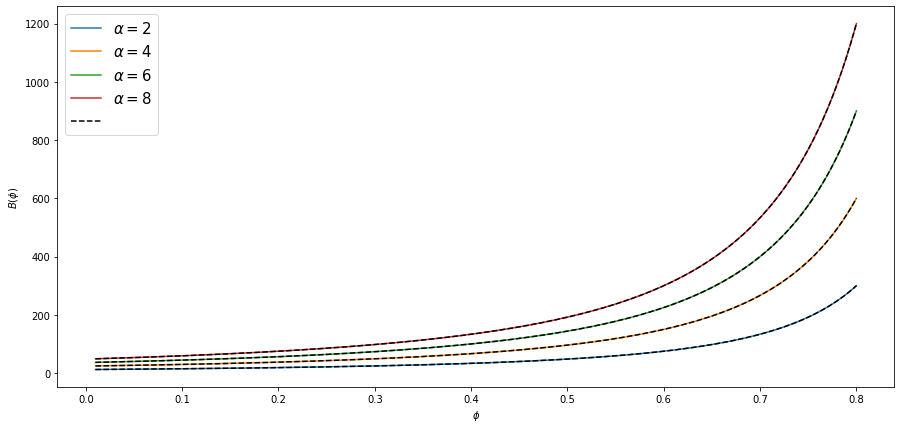

In [12]:
fig, ax = plt.subplots(figsize=(15,7))

analytical_solution_marker = plt.Line2D([0], [0], linestyle='--', color='black')
# Calcualte values from 0.01 to 0.8
x = np.linspace(0.01, 0.8, 500)
for alpha_value in [2, 4, 6, 8]:
    known_B = model.B.f_n(x, alpha=alpha_value, M_p=1)
    calculated_B = b_function.f_n(x, alpha=alpha_value, M_p=1)
    ax.plot(x, calculated_B, label=f"$\\alpha = {alpha_value}$")
    ax.plot(x, known_B, linestyle='--', color='black')

ax.legend(handles = ax.get_legend_handles_labels()[0] + [analytical_solution_marker], fontsize=15)
ax.set_ylabel("$B(\\phi)$")
ax.set_xlabel("$\\phi$")


We can see our result is correct function.

## 4) Calculate V
To calculate potential function we need to solve invariant scalar field integral. To derive solution for V we can see it easily why:
\begin{equation}
I_V(I_\phi) = \frac{V}{A^2} \Rightarrow V = A^2 I_V(I_\phi) 
\end{equation}

If user knows the solution for invariant field integral or sympy can solve it analytically then the result can be used to find result analytically. In our case let's do it numerically.

There is no unique initial condition (we can set integration contant usually the value we want to). To just compare if our calculated solution is same as given model's one we have to calculate specific values. Also one example is if we choose our condtion randomly.

In [13]:
v_solver = FunctionVsolver(model)

#### Calcualte initial conditon that corresponds to our model

In [14]:
# Find end value for invariant potential
end_value_solver = SlowRollEndSolver(model, invariant=True)
invariant_end = end_value_solver.nsolve_np([0, 2], params=parameters)[0]
# Find enc value for our A, B, V
end_value_solver2 = SlowRollEndSolver(model, invariant=False)
field_end = end_value_solver2.nsolve_np([0, 5], params=parameters)[0]

Numerical integration returns function which can evaluate solution 'continuously'.

In [15]:
# Solution with our defined solution. Important is  that invariant potential and potential
# have same sign as A must be positive.
calculate_iphi1 = v_solver.nsolve_field_np([0.1, 0.99], 0.1, params={M_p:1, alpha:2})
# To use mpmath use nsolve_field_mp
# Remember, B function has singularity at $phi=M_p$
calculate_iphi2 = v_solver.nsolve_field_np([field_end, 0.99], invariant_end, params={M_p:1, alpha:2})


In [16]:
# V function values for initial condition phi=0.1 -> I_phi = 0.1
V_solution1 = v_solver.nsolve_np(calculate_iphi1, np.linspace(0.1, 0.99), params={M_p:1, alpha:2})
# V funtion values for initial condition from our defined model
V_solution2 = v_solver.nsolve_np(calculate_iphi2, np.linspace(field_end, 0.99), params={M_p:1, alpha:2})

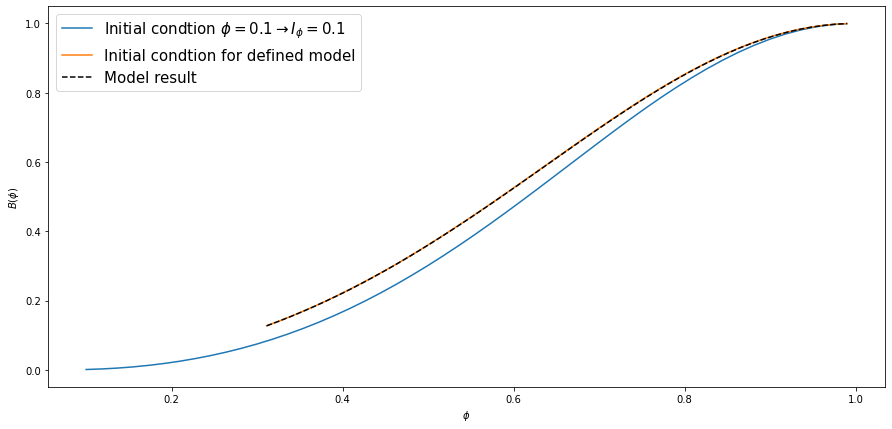

In [17]:
fig2, ax2 = plt.subplots(figsize=(15,7))

analytical_solution_marker = plt.Line2D([0], [0], linestyle='--', color='black', label='Model result')
# Calcualte values from 0.01 to 0.8

our_model_V = model.V.f_n(np.linspace(field_end, 0.99), alpha=2, M_p=1)

ax2.plot(np.linspace(0.1, 0.99), V_solution1, label=f"Initial condtion $\\phi=0.1 \\rightarrow I_{{\\phi}}=0.1$")
ax2.plot(np.linspace(field_end, 0.99), V_solution2, label=f"Initial condtion for defined model")
ax2.plot(np.linspace(field_end, 0.99), our_model_V, linestyle='--', color='black')

ax2.legend(handles = ax2.get_legend_handles_labels()[0] + [analytical_solution_marker], fontsize=15)
ax2.set_ylabel("$B(\\phi)$")
ax2.set_xlabel("$\\phi$");


We can see if we take right initial condition we can get the same potential. But the solution with blue line is alos correct but with other initial condition (integration constant).

Also aproaching singularity for B function we can see that both solutions converge at the same point.